# Explore the Dataset

## Import

In [1]:
import sys
import os

# Add paths for resolve 
INDOOR_COMPETITION_20_DIR = os.path.join("..", "indoor-location-competition-20")
sys.path.append(INDOOR_COMPETITION_20_DIR)
CODE_DIR = ".."
sys.path.append(CODE_DIR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

from py_indoor_loc.model import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.plot import plot_floor_map
from py_indoor_loc.sensors import compute_earth_acce_heading, compute_earth_acce_heading_ahrs
from py_indoor_loc.pdr.common import compute_step_heading, compute_rel_positions
from py_indoor_loc.pdr.common import RelPositionPredictor, compute_cumulative_step_positions
from py_indoor_loc.pdr.step_detection import AcfSDModel, LocalAcceVarianceSDModel, AngularRateSDModel
from py_indoor_loc.pdr.stride_length import WeinbergSLModel, ZUPTSLModel, RandomSLModel

In [108]:
from compute_f import compute_step_positions

In [98]:
from py_indoor_loc.zee import create_search_grid

In [3]:
np.random.seed(19)

In [4]:
def compute_path_length(waypoint):
  return np.linalg.norm(waypoint[1:, 1:] - waypoint[:-1, 1:], axis=1).sum()


def compute_path_duration_secs(waypoint):
  return (waypoint[-1, 0] - waypoint[0, 0]) / 1000

## Track Selection

In [5]:
TRAIN_DATA_DIR = "../../data/train/"

In [6]:
def list_tracks(site_id: str, floor_id: str, data_dir: str) -> list[str]:
  track_floor_path = os.path.join(data_dir, site_id, floor_id)
  return list(glob(track_floor_path + "/*.txt"))

* Compute length and duration of tracks

In [7]:
track_list = []

for site_path in glob(TRAIN_DATA_DIR + "/*"):
  site_id = os.path.basename(site_path)

  for floor_path in glob(site_path + "/*"):
    floor_id = os.path.basename(floor_path)
    
    for track_path in glob(floor_path + "/*.txt"):
      track_id = os.path.basename(track_path)[:-len(".txt")]
      
      track_list.append((site_id, floor_id, track_id))

In [9]:
track_df = pd.DataFrame(track_list, columns=["site_id", "floor_id", "track_id"])

In [12]:
track_df["site_id"].unique().shape[0]

204

In [16]:
track_df[["site_id", "floor_id"]].drop_duplicates().shape[0]

981

In [26]:
num_tracks_per_floor_df = (track_df.groupby(["site_id", "floor_id"])
                           .agg({"track_id": "count"})
                           .reset_index()
                           .rename(columns={"track_id": "num_tracks"})
                           .sort_values(by="num_tracks", ascending=False)
                           .reset_index(drop=True))

In [92]:
min_num_tracks = 75

* Statistics about the experiment areas

In [47]:
site_floor_stats = []

for site_id, floor_id in tqdm(track_df[["site_id", "floor_id"]].drop_duplicates().values):
  floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

  transform_func = lambda coords: coords

  (
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

  site_floor_stats.append({
    "site_id": site_id,
    "floor_id": floor_id,
    "width": width_meter,
    "height": height_meter,
    "area": floor_polygons[0].area
  })

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:07<00:00, 134.40it/s]


In [48]:
site_floor_stats_df = pd.DataFrame(site_floor_stats)

In [86]:
min_floor_area = 10000

In [87]:
site_floor_stats_df.loc[site_floor_stats_df["area"] >= min_floor_area, "width"].mean()

206.3102647284802

In [88]:
site_floor_stats_df.loc[site_floor_stats_df["area"] >= min_floor_area, "height"].mean()

195.2388718348184

In [89]:
site_floor_stats_df.loc[site_floor_stats_df["area"] >= min_floor_area, "area"].mean()

21818.05202495476

* Selected Site and Floor

In [93]:
eligible_site_and_floors = pd.merge(
    num_tracks_per_floor_df.loc[num_tracks_per_floor_df["num_tracks"] >=
                                min_num_tracks, ["site_id", "floor_id"]],
    site_floor_stats_df.loc[site_floor_stats_df["area"] >= min_floor_area,
                            ["site_id", "floor_id"]],
    how="inner",
    on=["site_id", "floor_id"])


* Data Coverage

In [152]:
site_id, floor_id = "5d27075f03f801723c2e360f", "F2"

In [153]:
waypoints = []

for track in list_tracks(site_id, floor_id, TRAIN_DATA_DIR):
  try:
    path_data_collection = read_data_file(track)
    positions = compute_step_positions(path_data_collection.acce, path_data_collection.ahrs, path_data_collection.waypoint)
    waypoints.append(positions[:, 1:])
  except Exception as ignored:
    pass

In [159]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

In [160]:
search_grid = create_search_grid(floor_polygons,
                                 store_polygons,
                                 width_meter,
                                 height_meter,
                                 grid_resolution=2.0,
                                 tol=1.0)

In [161]:
waypoint = np.concatenate(waypoints)

In [162]:
dists, indices = search_grid.nn.kneighbors(waypoint)

In [163]:
np.unique(indices).shape[0] / search_grid.n_points

0.6685768863419294

In [ ]:
search_grid.nn.kneighbors()

In [102]:
search_grid.nn.kneighbors()

1034

In [171]:
track_stats = []

for site_id, floor_id in tqdm(eligible_site_and_floors[["site_id", "floor_id"]].values):
  track_path_list = list_tracks(site_id, floor_id, TRAIN_DATA_DIR)

  for track_path in track_path_list:
    track_id = os.path.basename(track_path)[:-len(".txt")]
    try:
      path_data_collection = read_data_file(track_path)
      track_stats.append({
        "site_id": site_id,
        "floor_id": floor_id,
        "track_id": track_id,
        "duration": compute_path_duration_secs(path_data_collection.waypoint),
        "length": compute_path_length(path_data_collection.waypoint),
      })
    
    except Exception as ignored:
      pass

100%|██████████| 82/82 [15:32<00:00, 11.37s/it]


In [175]:
track_stats_df = pd.DataFrame(track_stats)

In [176]:
tmp = (track_stats_df.loc[track_stats_df["duration"] >= 30].groupby(["site_id", "floor_id"]).agg({"track_id": "count"})
 .reset_index()
 .rename(columns={"track_id": "n_tracks"})
 .sort_values("n_tracks", ascending=False))

In [188]:
pd.merge(track_stats_df.loc[track_stats_df["duration"] >= 30], tmp.loc[tmp["n_tracks"] >= 75, ["site_id", "floor_id"]],
         on=["site_id", "floor_id"],
         how="inner").to_csv("experiment_tracks.csv", index=False)

In [189]:
tmp.loc[tmp["n_tracks"] >= 75]

,site_id,floor_id,n_tracks
30,5d27075f03f801723c2e360f,F2,162
29,5d27075f03f801723c2e360f,F1,144
31,5d27075f03f801723c2e360f,F3,138
38,5d2709b303f801723c327472,1F,135
57,5da138b74db8ce0c98bd4774,B1,123
7,5cd56b6ae2acfd2d33b59ccb,B1,104
12,5cd56b6ae2acfd2d33b59ccb,F5,95
8,5cd56b6ae2acfd2d33b59ccb,F1,90
9,5cd56b6ae2acfd2d33b59ccb,F2,88
46,5d2709d403f801723c32bd39,B1,88


In [195]:
d = pd.merge(track_stats_df.loc[track_stats_df["duration"] >= 30], tmp.loc[tmp["n_tracks"] >= 75, ["site_id", "floor_id"]],
         on=["site_id", "floor_id"],
         how="inner")

In [196]:
site_floor_tracks = d.loc[(d["floor_id"] == floor_id) & (d["site_id"] == site_id)]

In [198]:
site_floor_tracks = [
  os.path.join(TRAIN_DATA_DIR, site_id, floor_id, track_id + ".txt")
  for track_id in d.loc[(d["floor_id"] == floor_id) & (d["site_id"] == site_id), "track_id"]
]

In [ ]:
site_id, floor_id = "5dc8cea7659e181adb076a3f", "F2"

floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)


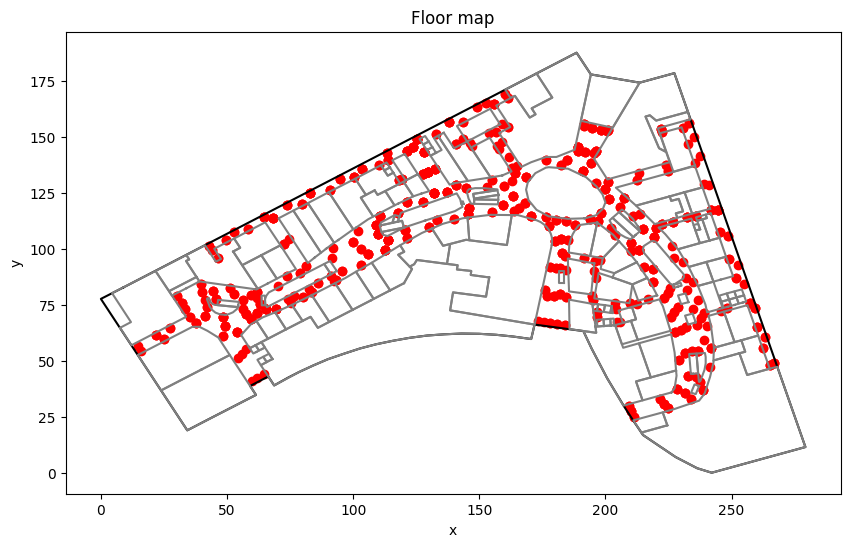

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

for track_path in site_floor_tracks:
  path_data_collection = read_data_file(track_path)
  ax.scatter(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

In [183]:
floor_polygons[0].area, width_meter, height_meter

(25696.276591348364, 279.2967348511189, 187.4620853494998)